<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [1]:
import torch
import transformers

import pandas as pd
import numpy as np
import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
data = pd.read_excel('/content/data_problems.xlsx', index_col=0)
labels_dict = dict((label, id_label) for id_label, label in enumerate(data['Тема'].unique()))
data['label'] = data['Тема'].replace(labels_dict)
data.reset_index(drop=True, inplace=True)

In [4]:
data

,Задача,Тема,label
0,Между девятью планетами Солнечной системы введ...,Графы,0
1,"В стране Цифра есть 9 городов с названиями 1, ...",Графы,0
2,"В государстве 100 городов, и из каждого из них...",Графы,0
3,"В классе 30 человек. Может ли быть так, что 9 ...",Графы,0
4,В городе Маленьком 15 телефонов. Можно ли их с...,Графы,0
...,...,...,...
5268,Дьявол предлагает Человеку сыграть в следующую...,Дирихле,6
5269,По шоссе в одном направлении едут 10 автомобил...,Дирихле,6
5270,В пространстве имеются 30 ненулевых векторов. ...,Дирихле,6
5271,На плоскости даны две точки A и B. Пусть C – н...,Дирихле,6


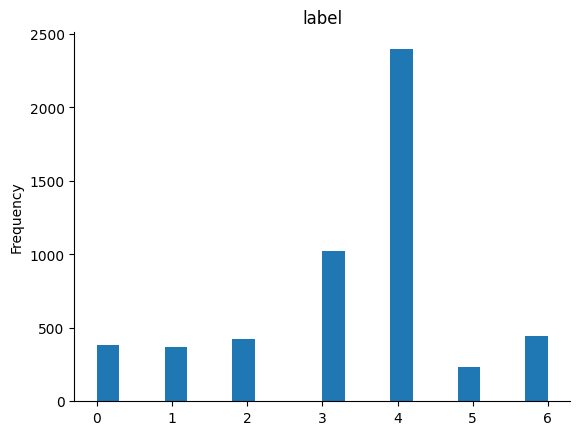

In [5]:
# @title label

from matplotlib import pyplot as plt
data['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
### This is just an interface example. You may change it if you want.

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: str,
                 hid_dim: int = 256,
                 device: torch.device = torch.device('cpu')):
      super().__init__()
      self.tokenizer = transformers.AutoTokenizer.from_pretrained(base_transformer_model)
      self.backbone = transformers.AutoModel.from_pretrained(base_transformer_model).to(device)
      if base_transformer_model == "cointegrated/rubert-tiny2":
        input_dim = 312
      elif base_transformer_model == "tbs17/MathBert":
        input_dim = 768

      self.clf = nn.Sequential(nn.Linear(input_dim, hid_dim),
                               nn.LeakyReLU(),
                               nn.Dropout(0.2),
                               nn.Linear(hid_dim, hid_dim),
                               nn.LeakyReLU(),
                               nn.Dropout(0.2),
                               nn.Linear(hid_dim, 7))
      self.softmax = nn.Softmax(dim=-1)
      self.hid_dim = hid_dim


    def forward(self, inputs):
        #print(inputs['input_ids'].shape)
        tf_out= self.backbone(inputs['input_ids'], attention_mask=inputs['attention_mask']).last_hidden_state[:, 0, :]
        outputs = self.softmax(self.clf(tf_out))
        return outputs

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [7]:
def freeze_backbone_function(model: TransformerClassificationModel):
  for w in model.backbone.parameters():
    w._trainable = False

  return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [8]:
class myDataset(Dataset):
    """CustomDataset for task"""

    def __init__(self,
                 base_transformer_model: str,
                 ids: list
                 ):

        data = pd.read_excel('/content/data_problems.xlsx', index_col=0)
        labels_dict = dict((label, id_label) for id_label, label in enumerate(data['Тема'].unique()))
        data['label'] = data['Тема'].replace(labels_dict)
        data.reset_index(drop=True, inplace=True)

        self.tokenizer = transformers.AutoTokenizer.from_pretrained(base_transformer_model)

        list_data = list(data.iloc[ids]['Задача'])
        self.labels = list(data.iloc[ids]['label'])

        self.data = self.tokenizer(list_data,
                                   max_length=256,
                                   truncation=True,
                                   padding='max_length')

    def __len__(self):
        return len(self.data['input_ids'])

    def __getitem__(self, idx):

        data_item = {'input_ids':torch.tensor(self.data['input_ids'][idx]).to(device).squeeze(0),
                     'attention_mask':torch.tensor(self.data['attention_mask'][idx]).to(device)}


        label_item = torch.tensor(self.labels[idx]).to(device)

        return data_item, label_item

In [9]:
def train_transformer(model,
                      device,
                      train_dataloader,
                      test_dataloader,
                      freeze_backbone=True,
                      n_epochs=1):

  model = model.to(device)
  if freeze_backbone:
    model = freeze_backbone_function(model)

  optim = torch.optim.AdamW(model.parameters(), lr=5e-6)
  loss_fn = nn.CrossEntropyLoss()

  train_loss = []
  test_loss = []

  for epoch in tqdm(range(n_epochs)):
      model.train()
      train_epoch_loss = []
      for X_batch, y_batch in train_dataloader:

          optim.zero_grad()

          output = model(X_batch)

          loss = loss_fn(output, y_batch)

          loss.backward()
          optim.step()

          train_epoch_loss.append(loss.cpu().detach().numpy())

      train_loss.append(np.mean(train_epoch_loss))

      model.eval()

      test_epoch_loss = []
      acc = 0
      len_test = 0

      for X_batch_test, y_batch_test in test_dataloader:
          output_test = model(X_batch_test)

          loss = loss_fn(output_test, y_batch_test)

          test_epoch_loss.append(loss.cpu().detach().numpy())

          acc += torch.sum(torch.argmax(output_test, 1) == y_batch_test).float().cpu().detach().numpy()
          len_test +=  y_batch_test.size()[0]

      print(' Test accuracy = ', round(acc / len_test, 4))

      test_loss.append(np.mean(test_epoch_loss))

  return model, (train_loss, test_loss)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['Задача']],
                                                    data[['label']],
                                                    stratify=data[['label']],
                                                    test_size=0.2,
                                                    random_state=42)

#обрезаем данные мажоритарных классов чтобы сгладить дисбаланс
major_class_index_trunc = y_train[y_train['label'] == 4].index.to_list()[0:400]
major_class_index_trunc.extend(y_train[y_train['label'] == 3].index.to_list()[0:400])

train_ids = y_train[(y_train.index.isin(major_class_index_trunc)) | (y_train['label'].isin([0,1,2,5,6]))].index.tolist()
test_ids = X_test.index.tolist()

In [11]:
base_transformer_model = "tbs17/MathBert"

train_dataset = myDataset(base_transformer_model, train_ids) # create your datset
test_dataset = myDataset(base_transformer_model, test_ids)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

mathbert_model = TransformerClassificationModel(base_transformer_model, 256, device=device)
mathbert_model_with_freezed_backbone, losses = train_transformer(mathbert_model,
                                  device=device,
                                  train_dataloader=train_dataloader,
                                  test_dataloader=test_dataloader,
                                  freeze_backbone=True,
                                  n_epochs=7)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

 14%|█▍        | 1/7 [01:51<11:09, 111.54s/it]

 Test accuracy =  0.363


 29%|██▊       | 2/7 [03:43<09:18, 111.67s/it]

 Test accuracy =  0.3346


 43%|████▎     | 3/7 [05:35<07:27, 111.76s/it]

 Test accuracy =  0.3839


 57%|█████▋    | 4/7 [07:27<05:35, 111.81s/it]

 Test accuracy =  0.364


 71%|███████▏  | 5/7 [09:18<03:43, 111.80s/it]

 Test accuracy =  0.4891


 86%|████████▌ | 6/7 [11:10<01:51, 111.86s/it]

 Test accuracy =  0.455


100%|██████████| 7/7 [13:02<00:00, 111.81s/it]

 Test accuracy =  0.455


In [12]:
def plot_util(losses):
  plt.plot(np.arange(len(losses[0])), losses[0], label='Train')
  plt.plot(np.arange(len(losses[1])), losses[1], label='Test')
  plt.xlabel('№ Epochs')
  plt.ylabel('CELoss')
  plt.legend()
  plt.grid()

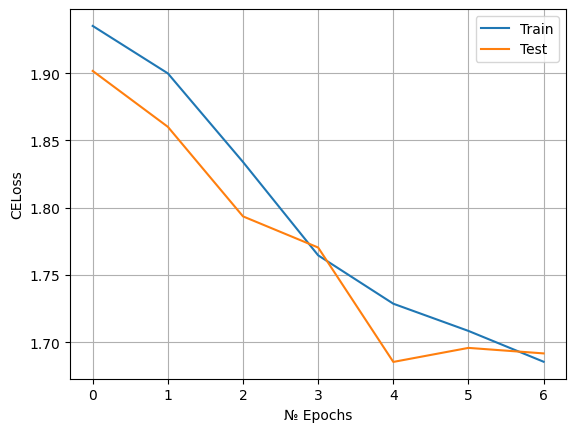

In [13]:
plot_util(losses)

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [14]:
rubert_tiny_transformer_model = 'cointegrated/rubert-tiny2'
train_dataset = myDataset(rubert_tiny_transformer_model, train_ids) # create your datset
test_dataset = myDataset(rubert_tiny_transformer_model, test_ids)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)


rubert_tiny_model = TransformerClassificationModel(rubert_tiny_transformer_model,
                                                   256,
                                                   device=device)
rubert_tiny_finetuned_with_freezed_backbone, losses = train_transformer(rubert_tiny_model,
                                                                        device=device,
                                                                        train_dataloader=train_dataloader,
                                                                        test_dataloader=test_dataloader,
                                                                        freeze_backbone=True,
                                                                        n_epochs=30)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

  3%|▎         | 1/30 [00:08<04:08,  8.57s/it]

 Test accuracy =  0.3915


  7%|▋         | 2/30 [00:17<03:59,  8.55s/it]

 Test accuracy =  0.454


 10%|█         | 3/30 [00:25<03:50,  8.55s/it]

 Test accuracy =  0.419


 13%|█▎        | 4/30 [00:34<03:42,  8.56s/it]

 Test accuracy =  0.4104


 17%|█▋        | 5/30 [00:42<03:34,  8.56s/it]

 Test accuracy =  0.3991


 20%|██        | 6/30 [00:51<03:26,  8.58s/it]

 Test accuracy =  0.3953


 23%|██▎       | 7/30 [00:59<03:16,  8.55s/it]

 Test accuracy =  0.3877


 27%|██▋       | 8/30 [01:10<03:20,  9.10s/it]

 Test accuracy =  0.4076


 30%|███       | 9/30 [01:20<03:16,  9.36s/it]

 Test accuracy =  0.4133


 33%|███▎      | 10/30 [01:28<03:02,  9.15s/it]

 Test accuracy =  0.454


 37%|███▋      | 11/30 [01:37<02:51,  9.01s/it]

 Test accuracy =  0.4758


 40%|████      | 12/30 [01:46<02:39,  8.87s/it]

 Test accuracy =  0.5024


 43%|████▎     | 13/30 [01:54<02:29,  8.78s/it]

 Test accuracy =  0.5118


 47%|████▋     | 14/30 [02:03<02:19,  8.69s/it]

 Test accuracy =  0.5204


 50%|█████     | 15/30 [02:11<02:09,  8.65s/it]

 Test accuracy =  0.5147


 53%|█████▎    | 16/30 [02:20<02:00,  8.62s/it]

 Test accuracy =  0.5441


 57%|█████▋    | 17/30 [02:28<01:51,  8.60s/it]

 Test accuracy =  0.5393


 60%|██████    | 18/30 [02:37<01:43,  8.58s/it]

 Test accuracy =  0.5441


 63%|██████▎   | 19/30 [02:45<01:34,  8.58s/it]

 Test accuracy =  0.5327


 67%|██████▋   | 20/30 [02:54<01:27,  8.74s/it]

 Test accuracy =  0.5583


 70%|███████   | 21/30 [03:03<01:17,  8.66s/it]

 Test accuracy =  0.5555


 73%|███████▎  | 22/30 [03:12<01:09,  8.64s/it]

 Test accuracy =  0.545


 77%|███████▋  | 23/30 [03:20<01:00,  8.62s/it]

 Test accuracy =  0.5346


 80%|████████  | 24/30 [03:29<00:51,  8.59s/it]

 Test accuracy =  0.546


 83%|████████▎ | 25/30 [03:37<00:42,  8.58s/it]

 Test accuracy =  0.5393


 87%|████████▋ | 26/30 [03:46<00:34,  8.57s/it]

 Test accuracy =  0.5194


 90%|█████████ | 27/30 [03:54<00:25,  8.58s/it]

 Test accuracy =  0.5251


 93%|█████████▎| 28/30 [04:03<00:17,  8.55s/it]

 Test accuracy =  0.5289


 97%|█████████▋| 29/30 [04:11<00:08,  8.55s/it]

 Test accuracy =  0.5232


100%|██████████| 30/30 [04:20<00:00,  8.68s/it]

 Test accuracy =  0.5223


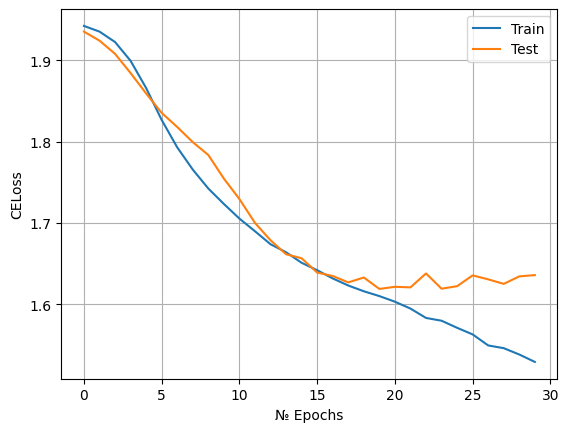

In [15]:
plot_util(losses)

In [16]:
rubert_tiny_transformer_model = 'cointegrated/rubert-tiny2'
train_dataset = myDataset(rubert_tiny_transformer_model, train_ids) # create your datset
test_dataset = myDataset(rubert_tiny_transformer_model, test_ids)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)


rubert_tiny_model = TransformerClassificationModel(rubert_tiny_transformer_model,
                                                   512,
                                                   device=device)
rubert_tiny_finetuned_no_freezed_backbone, losses = train_transformer(rubert_tiny_model,
                                                                device=device,
                                                                train_dataloader=train_dataloader,
                                                                test_dataloader=test_dataloader,
                                                                freeze_backbone=False,
                                                                n_epochs=30)

  3%|▎         | 1/30 [00:08<04:09,  8.62s/it]

 Test accuracy =  0.1687


  7%|▋         | 2/30 [00:17<03:58,  8.53s/it]

 Test accuracy =  0.2398


 10%|█         | 3/30 [00:25<03:50,  8.55s/it]

 Test accuracy =  0.3005


 13%|█▎        | 4/30 [00:34<03:42,  8.57s/it]

 Test accuracy =  0.3564


 17%|█▋        | 5/30 [00:42<03:34,  8.56s/it]

 Test accuracy =  0.3754


 20%|██        | 6/30 [00:51<03:25,  8.55s/it]

 Test accuracy =  0.4152


 23%|██▎       | 7/30 [00:59<03:17,  8.57s/it]

 Test accuracy =  0.4483


 27%|██▋       | 8/30 [01:08<03:09,  8.60s/it]

 Test accuracy =  0.4654


 30%|███       | 9/30 [01:17<03:00,  8.57s/it]

 Test accuracy =  0.4806


 33%|███▎      | 10/30 [01:25<02:51,  8.56s/it]

 Test accuracy =  0.4825


 37%|███▋      | 11/30 [01:34<02:42,  8.56s/it]

 Test accuracy =  0.4749


 40%|████      | 12/30 [01:42<02:33,  8.54s/it]

 Test accuracy =  0.4815


 43%|████▎     | 13/30 [01:51<02:25,  8.54s/it]

 Test accuracy =  0.5014


 47%|████▋     | 14/30 [01:59<02:16,  8.55s/it]

 Test accuracy =  0.49


 50%|█████     | 15/30 [02:08<02:08,  8.57s/it]

 Test accuracy =  0.5014


 53%|█████▎    | 16/30 [02:16<01:59,  8.55s/it]

 Test accuracy =  0.5118


 57%|█████▋    | 17/30 [02:25<01:51,  8.55s/it]

 Test accuracy =  0.5005


 60%|██████    | 18/30 [02:34<01:42,  8.56s/it]

 Test accuracy =  0.5213


 63%|██████▎   | 19/30 [02:42<01:33,  8.54s/it]

 Test accuracy =  0.5071


 67%|██████▋   | 20/30 [02:51<01:25,  8.55s/it]

 Test accuracy =  0.5118


 70%|███████   | 21/30 [02:59<01:17,  8.56s/it]

 Test accuracy =  0.5346


 73%|███████▎  | 22/30 [03:08<01:08,  8.56s/it]

 Test accuracy =  0.5071


 77%|███████▋  | 23/30 [03:16<00:59,  8.55s/it]

 Test accuracy =  0.5365


 80%|████████  | 24/30 [03:25<00:51,  8.57s/it]

 Test accuracy =  0.5422


 83%|████████▎ | 25/30 [03:35<00:44,  8.87s/it]

 Test accuracy =  0.5299


 87%|████████▋ | 26/30 [03:43<00:35,  8.77s/it]

 Test accuracy =  0.5327


 90%|█████████ | 27/30 [03:52<00:26,  8.80s/it]

 Test accuracy =  0.527


 93%|█████████▎| 28/30 [04:01<00:17,  8.84s/it]

 Test accuracy =  0.5327


 97%|█████████▋| 29/30 [04:10<00:09,  9.04s/it]

 Test accuracy =  0.5232


100%|██████████| 30/30 [04:20<00:00,  8.67s/it]

 Test accuracy =  0.528


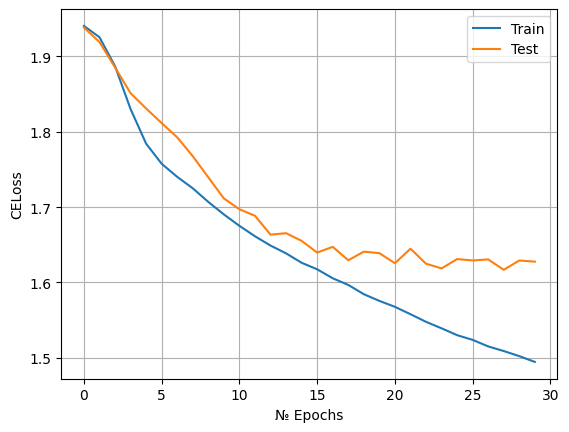

In [17]:
plot_util(losses)

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [18]:
base_transformer_model = "tbs17/MathBert"

train_dataset = myDataset(base_transformer_model, train_ids) # create your datset
test_dataset = myDataset(base_transformer_model, test_ids)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

mathbert_nofreeze = TransformerClassificationModel(base_transformer_model, 256, device=device)
mathbert_nofreeze, losses = train_transformer(mathbert_nofreeze,
                                  device=device,
                                  train_dataloader=train_dataloader,
                                  test_dataloader=test_dataloader,
                                  freeze_backbone=False,
                                  n_epochs=7)

 14%|█▍        | 1/7 [01:53<11:20, 113.49s/it]

 Test accuracy =  0.2455


 29%|██▊       | 2/7 [03:46<09:26, 113.35s/it]

 Test accuracy =  0.4417


 43%|████▎     | 3/7 [05:39<07:31, 112.87s/it]

 Test accuracy =  0.4578


 57%|█████▋    | 4/7 [07:30<05:37, 112.49s/it]

 Test accuracy =  0.5374


 71%|███████▏  | 5/7 [09:22<03:44, 112.27s/it]

 Test accuracy =  0.5403


 86%|████████▌ | 6/7 [11:14<01:52, 112.13s/it]

 Test accuracy =  0.5564


100%|██████████| 7/7 [13:06<00:00, 112.36s/it]

 Test accuracy =  0.5469


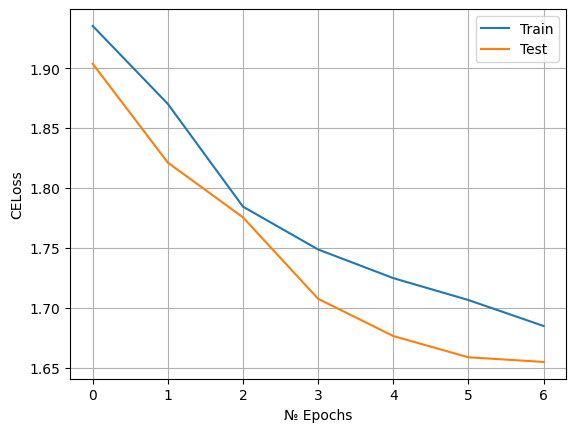

In [19]:
plot_util(losses)

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

## Примечание
Для удобства я написал функцию так, чтобы на одном графике в разных подграфиках отображались одновременно heatmap слоя для модели до и после дообучения для удобства сравнения

В этом пункте графики для MathBERT

В следующем пункте графики для ruBERT

In [33]:
import seaborn as sns
def draw_first_layer_attention_maps(attention_head_ids: list,
                                    text_idx: int,
                                    model_before_ft: TransformerClassificationModel,
                                    model_after_ft: TransformerClassificationModel):

  data = pd.read_excel('/content/data_problems.xlsx', index_col=0)
  labels_dict = dict((label, id_label) for id_label, label in enumerate(data['Тема'].unique()))
  data['label'] = data['Тема'].replace(labels_dict)

  data = data.sample(frac=1, random_state=42).reset_index(drop=True)

  tokenizer = transformers.AutoTokenizer.from_pretrained(base_transformer_model)

  list_data = data['Задача'].tolist()
  labels = data['label'].tolist()

  data_tokens = tokenizer(list_data,
                   max_length=64,
                   truncation=True,
                   padding="max_length",
                  return_tensors="pt")

  input_ids = data_tokens['input_ids'][text_idx:text_idx+1].to(device)
  input_attns = data_tokens['attention_mask'][text_idx:text_idx+1].to(device)
  xticklabels = tokenizer.convert_ids_to_tokens(input_ids[0])

  model_before_ft.eval()
  model_after_ft.eval()

  first_layer_output_bft = model_before_ft.backbone(input_ids, attention_mask=input_attns, output_attentions=True).attentions[0][0]
  first_layer_output_aft = model_after_ft.backbone(input_ids, attention_mask=input_attns, output_attentions=True).attentions[0][0]

  list_plot = []
  for i in attention_head_ids:
    bft_otput = first_layer_output_bft[i].float().detach().cpu().numpy()
    aft_otput = first_layer_output_aft[i].float().detach().cpu().numpy()
    list_plot.append((bft_otput, aft_otput))

  fig, axes = plt.subplots(2, 2, figsize=(16, 16))

  # Отображаем heatmap на каждом axes с помощью Seaborn
  sns.heatmap(list_plot[0][0], ax=axes[0, 0], cmap='hot', square=True, xticklabels=xticklabels, yticklabels=xticklabels)
  sns.heatmap(list_plot[0][1], ax=axes[0, 1], cmap='hot', square=True, xticklabels=xticklabels, yticklabels=xticklabels)
  sns.heatmap(list_plot[1][0], ax=axes[1, 0], cmap='hot', square=True, xticklabels=xticklabels, yticklabels=xticklabels)
  sns.heatmap(list_plot[1][1], ax=axes[1, 1], cmap='hot', square=True, xticklabels=xticklabels, yticklabels=xticklabels)

  axes[0, 0].set_title(f'Heatmap {attention_head_ids[0]} layer before fine-tuning')
  axes[0, 1].set_title(f'Heatmap {attention_head_ids[0]} layer after fine-tuning')
  axes[1, 0].set_title(f'Heatmap {attention_head_ids[1]} layer before fine-tuning')
  axes[1, 1].set_title(f'Heatmap {attention_head_ids[1]} layer after fine-tuning')

  for ax in axes.flatten():
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

  # Отображаем график
  plt.show()

  pass

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [38]:
mathbert_model = TransformerClassificationModel("tbs17/MathBert", 256, device=device)
rubert_model = TransformerClassificationModel("cointegrated/rubert-tiny2", 256, device=device)

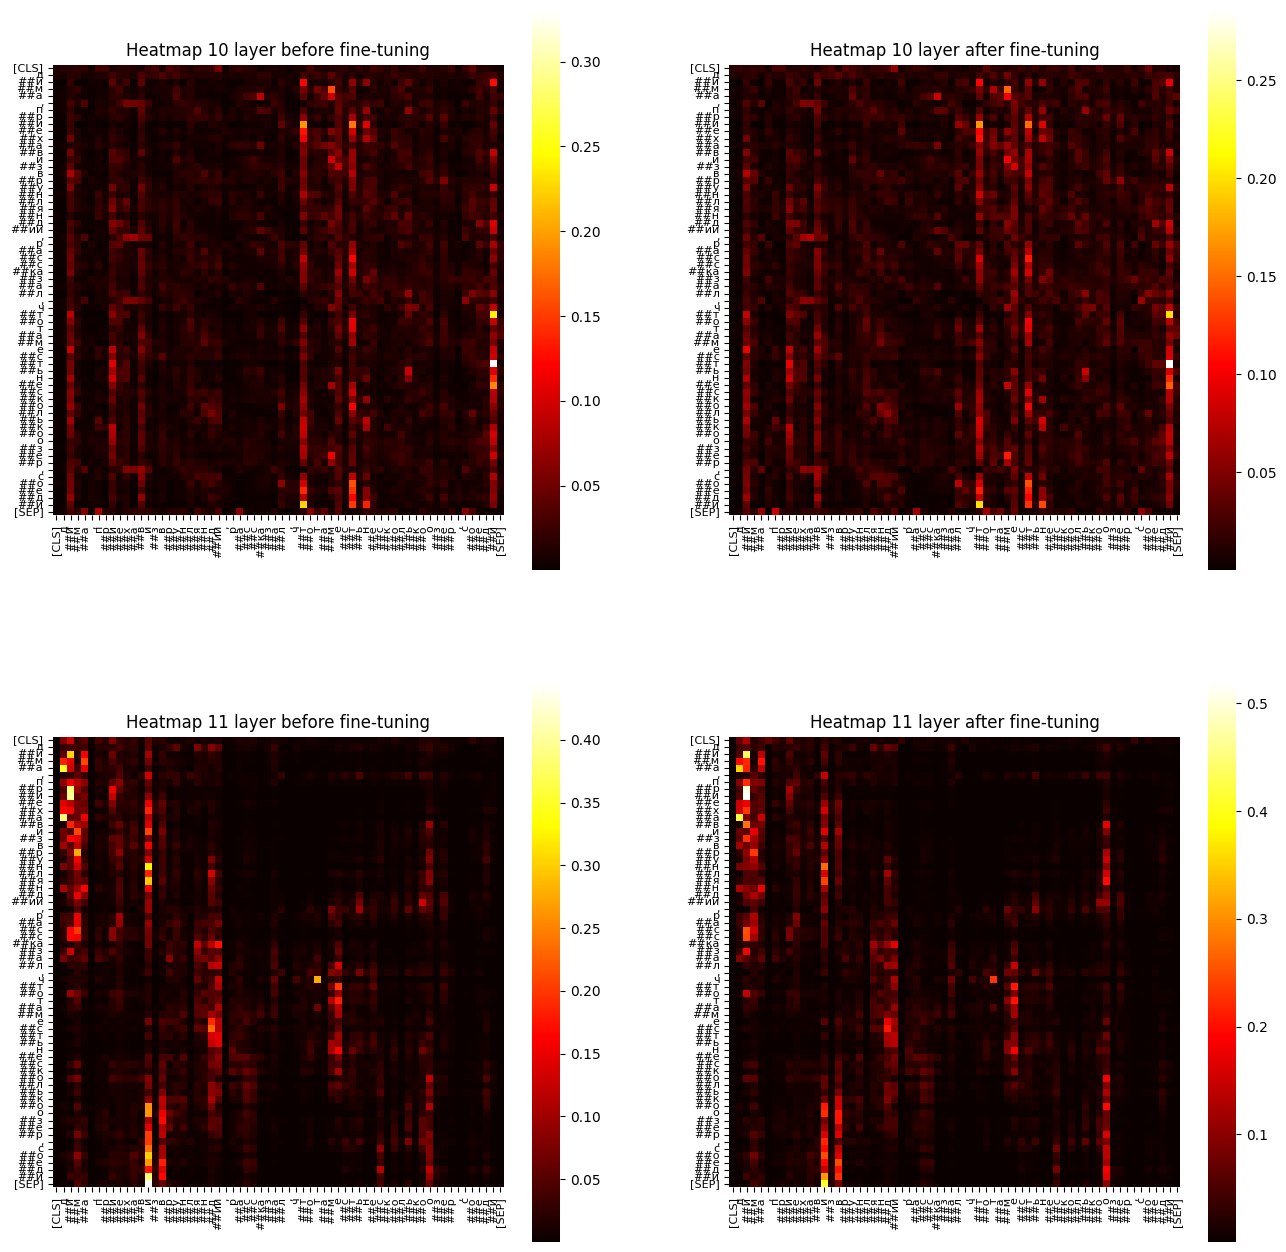

In [44]:
draw_first_layer_attention_maps(attention_head_ids=[10,11],
                                text_idx=0,
                                model_before_ft=mathbert_model,
                                model_after_ft=mathbert_nofreeze)

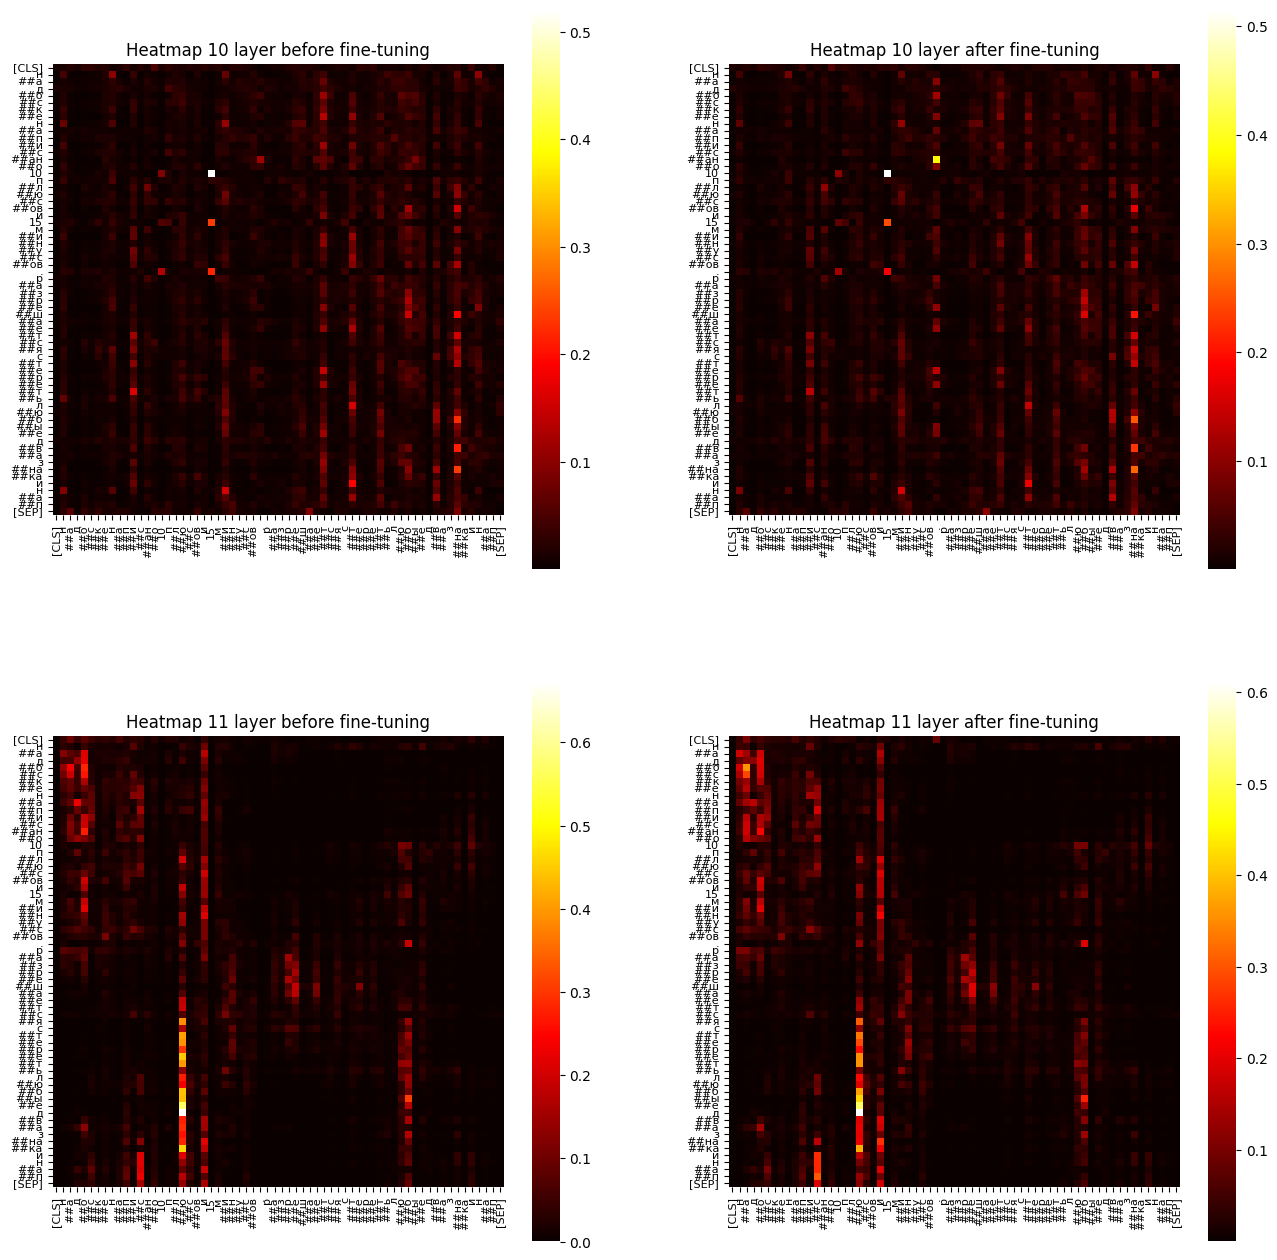

In [45]:
draw_first_layer_attention_maps(attention_head_ids=[10, 11],
                                text_idx=1,
                                model_before_ft=mathbert_model,
                                model_after_ft=mathbert_nofreeze)

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

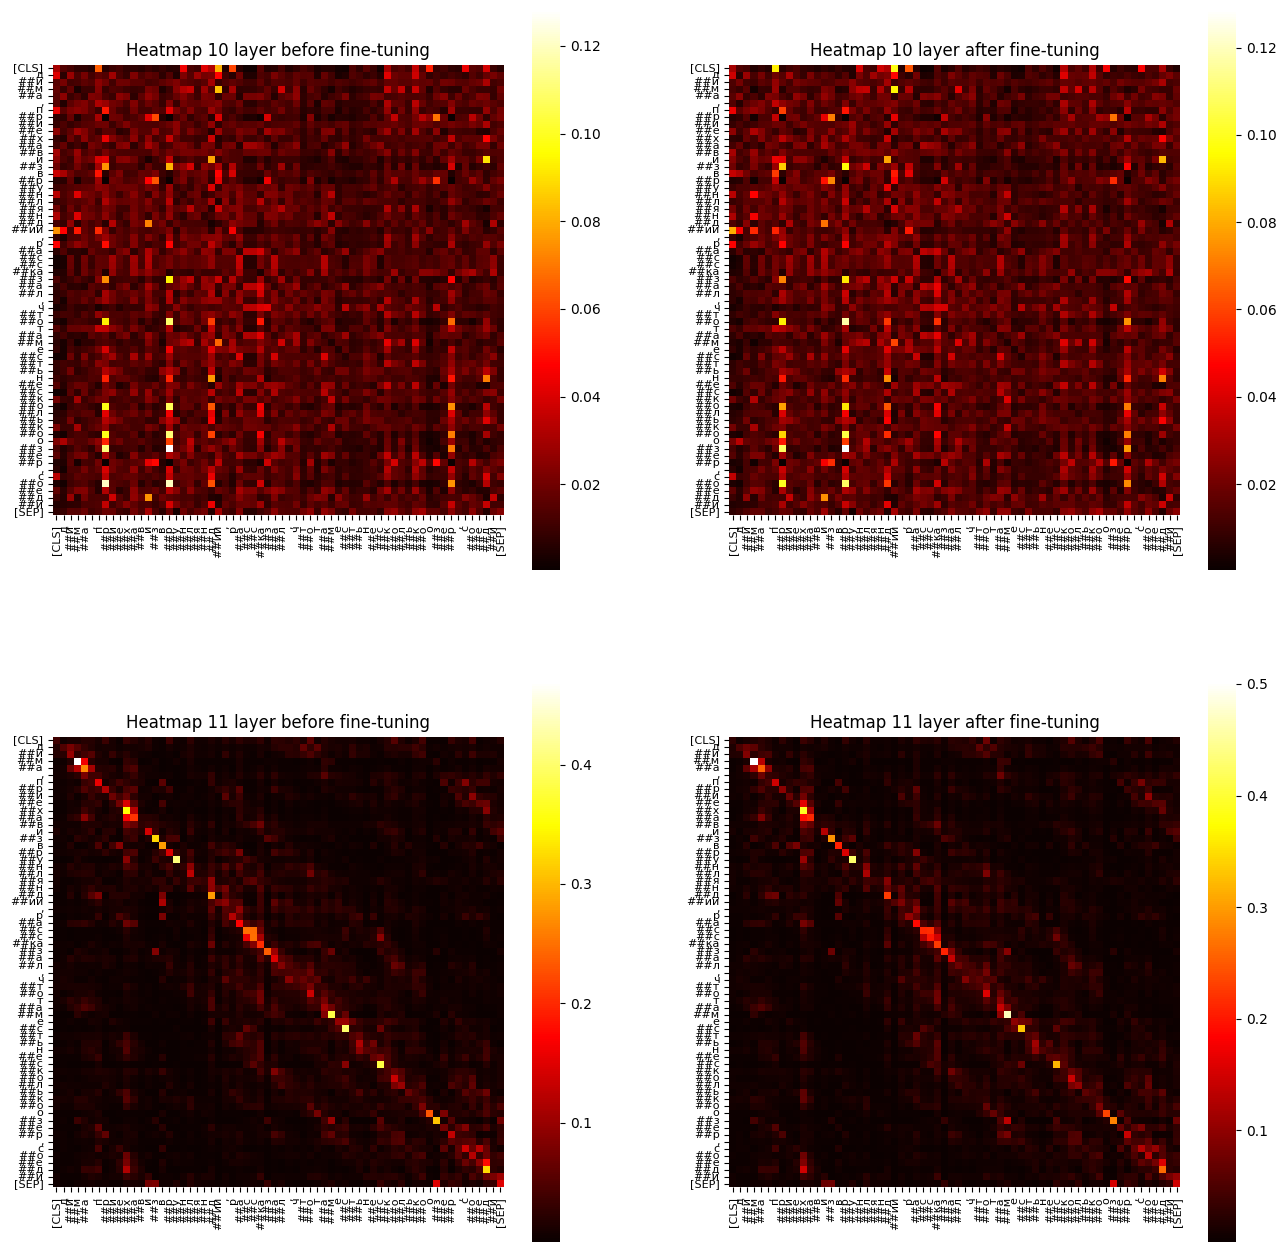

In [46]:
draw_first_layer_attention_maps(attention_head_ids=[10, 11],
                                text_idx=0,
                                model_before_ft=rubert_model,
                                model_after_ft=rubert_tiny_finetuned_no_freezed_backbone)

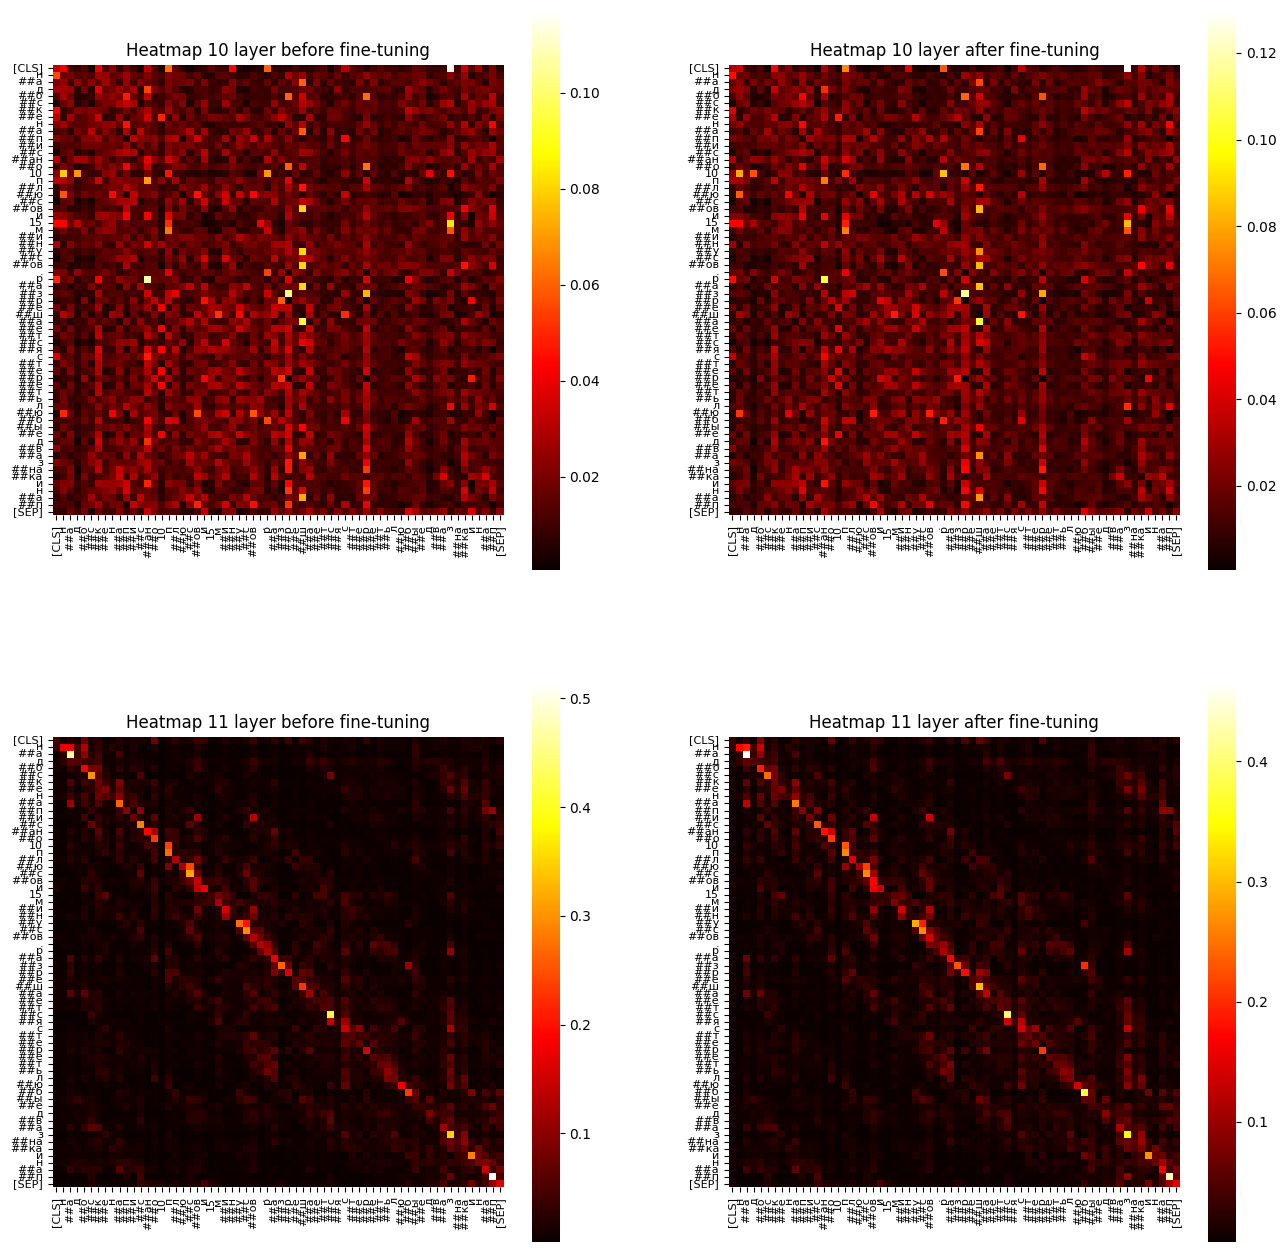

In [47]:
draw_first_layer_attention_maps(attention_head_ids=[10, 11],
                                text_idx=1,
                                model_before_ft=rubert_model,
                                model_after_ft=rubert_tiny_finetuned_no_freezed_backbone)

### Вывод
Создалось впечатление, что тепловые карты голов для ruBERT несут больший смысл так как большие значения в матрицах содержатся вблизи диагоналей, это может говорить о том, что в первую очредь внимание обращается к ближайшим к токену другим токенам.
Также стоит заметить, что не видно большой разницы между в матрицах attention до и после обучения, так как вероятно, что изменениям подвергаются в первую очередь последние слои, где и находится классификатор, к тому же процесс обучения занимал всего лишь несколько эпох, что судя по всему мало для заметных изменений   